In [ ]:
!pip install -q tensorflow
!pip install -q scikit-learn
!pip install -q matplotlib
!pip install -q pandas


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
csv_file = '/content/drive/MyDrive/lstm_training/main_meter_years_data.csv'

csv_file


'/content/drive/MyDrive/lstm_training/main_meter_years_data.csv'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from pandas import read_csv
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from datetime import timedelta

years_data:                                 kW
minute                           
2021-11-16 23:00:00  18643.000000
2021-11-16 23:15:00  17689.533333
2021-11-16 23:30:00  16833.066667
2021-11-16 23:45:00  15887.200000
2021-11-17 00:00:00  16615.133333
years_data:                    kW
count   37981.000000
mean    23732.081099
std     14696.754896
min     -5277.466667
25%     14551.266667
50%     16442.600000
75%     31473.600000
max    106544.333333


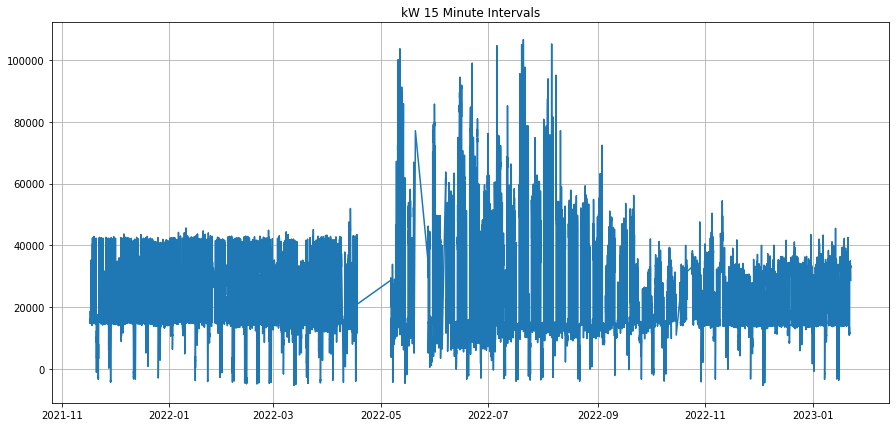

Epoch 1/25
25158/25158 - 46s - loss: 0.0041 - 46s/epoch - 2ms/step
Epoch 2/25
25158/25158 - 43s - loss: 0.0025 - 43s/epoch - 2ms/step
Epoch 3/25
25158/25158 - 42s - loss: 0.0022 - 42s/epoch - 2ms/step
Epoch 4/25
25158/25158 - 41s - loss: 0.0020 - 41s/epoch - 2ms/step
Epoch 5/25
25158/25158 - 41s - loss: 0.0019 - 41s/epoch - 2ms/step
Epoch 6/25
25158/25158 - 41s - loss: 0.0018 - 41s/epoch - 2ms/step
Epoch 7/25
25158/25158 - 41s - loss: 0.0018 - 41s/epoch - 2ms/step
Epoch 8/25
25158/25158 - 41s - loss: 0.0018 - 41s/epoch - 2ms/step
Epoch 9/25
25158/25158 - 41s - loss: 0.0017 - 41s/epoch - 2ms/step
Epoch 10/25
25158/25158 - 41s - loss: 0.0016 - 41s/epoch - 2ms/step
Epoch 11/25
25158/25158 - 41s - loss: 0.0016 - 41s/epoch - 2ms/step
Epoch 12/25
25158/25158 - 41s - loss: 0.0016 - 41s/epoch - 2ms/step
Epoch 13/25
25158/25158 - 42s - loss: 0.0015 - 42s/epoch - 2ms/step
Epoch 14/25
25158/25158 - 41s - loss: 0.0015 - 41s/epoch - 2ms/step
Epoch 15/25
25158/25158 - 41s - loss: 0.0015 - 41s/epoch 

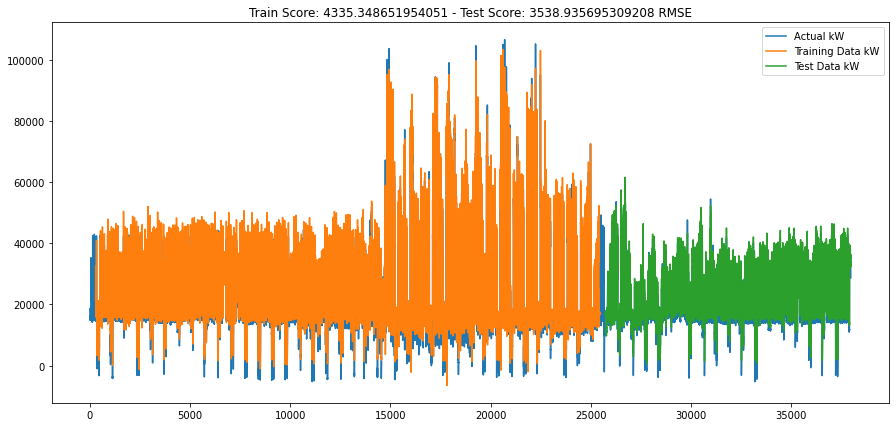

In [ ]:
EPOCHS = 25
DAYS = 3
LOOK_BACK = 96 * DAYS # number of 15 min intervals in one day


power = read_csv(csv_file, index_col=[0], parse_dates=True)
power = power[['avg']]
power = power.rename({'avg': 'kW'}, axis=1)
print("years_data: ",power.head())
print("years_data: ",power.describe())
plt.figure(figsize=(15, 7))
plt.plot(power.kW)
plt.title('kW 15 Minute Intervals')
plt.grid(True)
plt.show()
#plt.savefig('./images/power.png')



# for LSTM
# https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(power.values)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# reshape into X=t and Y=t+1
trainX, trainY = create_dataset(train, LOOK_BACK)
testX, testY = create_dataset(test, LOOK_BACK)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, LOOK_BACK)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=EPOCHS, batch_size=1, verbose=2)

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
trainTestStr = f'Train Score: {trainScore} - Test Score: {testScore} RMSE'
print(trainTestStr)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[LOOK_BACK:len(trainPredict)+LOOK_BACK, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(LOOK_BACK*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.figure(figsize=(15, 7))
plt.plot(scaler.inverse_transform(dataset), label='Actual kW')
plt.plot(trainPredictPlot, label='Training Data kW')
plt.plot(testPredictPlot, label='Test Data kW')
plt.legend()
plt.title(trainTestStr)
plt.show()
#plt.savefig('./images/train_test.png')

# save model
model.save('3_day')